In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, ConcatDataset

from torchvision.datasets import Cityscapes

# Notebooks for depth map calculation, fog generation, and model training on city scapes dataset

In [2]:
root = os.getcwd()
cityscapes_path = os.path.join(root, 'cityscapes')

In [3]:
data_transforms = {
            'train': transforms.Compose([transforms.ToTensor()]),
            'val': transforms.Compose([transforms.ToTensor()]),
            'test': transforms.Compose([transforms.ToTensor()])}

In [4]:
important_classes = ['unlabeled',
 'ground',
 'road',
 'sidewalk',
 'parking',
 'rail track',
 'building',
 'fence',
 'guard rail',
 'bridge',
 'tunnel',
 'person',
 'rider',
 'car',
 'truck',
 'bus',
 'caravan',
 'trailer',
 'train',
 'motorcycle',
 'bicycle']

class_to_num = {label: i for i, label in enumerate(important_classes)}

In [5]:
def get_image_label(poly):
    objects = poly['objects']
    
    image_label = 'unlabeled'
    max_count = 0
    label_counts = {}
    
    for obj in objects:
        label = obj['label']
        
        if label in important_classes:
            label_counts[label] = label_counts.get(label, 0) + 1

            if label_counts[label] > max_count:
                max_count = label_counts[label]
                image_label = label
    
    label_num = class_to_num[image_label]
    
    target = torch.zeros(len(important_classes), dtype=torch.float32)
    target[label_num] = 1
    return target

In [6]:
train_dataset = Cityscapes(cityscapes_path,
                          split='train',
                          mode='fine',
                          target_type=["polygon"],
                          transform = data_transforms['train'],
                          target_transform = get_image_label)

In [7]:
trainextra_dataset = Cityscapes(cityscapes_path,
                          split='train_extra',
                          mode='coarse',
                          target_type=["polygon"],
                          transform = data_transforms['train'],
                          target_transform = get_image_label)

In [8]:
train_dataset = ConcatDataset([train_dataset, trainextra_dataset])

In [9]:
val_dataset = Cityscapes(cityscapes_path,
                          split='val',
                          mode='coarse',
                          target_type=['polygon'],
                          transform = data_transforms['val'],
                          target_transform = get_image_label)

In [10]:
test_dataset = Cityscapes(cityscapes_path,
                          split='test',
                          mode='fine',
                          target_type=["instance", "semantic", "polygon", "color"],
                          transform = data_transforms['test'],
                          target_transform = get_image_label)

In [11]:
print('Training: {} Val: {} Test: {}'.format(
                                train_dataset.__len__(), val_dataset.__len__(), test_dataset.__len__()))

Training: 22973 Val: 500 Test: 1525


In [12]:
num_workers = 1
bs = 16

In [13]:
dataloaders = {'train': DataLoader(train_dataset, batch_size = bs, shuffle=True, num_workers=num_workers),
               'val': DataLoader(val_dataset, batch_size = bs, shuffle=True, num_workers=num_workers),
               'test': DataLoader(test_dataset, batch_size = 1, shuffle=True, num_workers=num_workers)}

In [14]:
# Plots a given number of images from a PyTorch Data
def show_random_imgs(num_imgs, dataset):
  
    for i in range(num_imgs):
        # Choose a random image
        rand = np.random.randint(0, len(dataset))
        
        # Read in the image
        ex = train_dataset[rand][0].numpy().transpose(1,2,0)
        
        # Get the image's label
        label = important_classes[torch.argmax(train_dataset[rand][1])]
        
        # Show the image and print out the image's size (really the shape of it's array of pixels)
        plt.imshow(ex)
        plt.axis('off')
        plt.title(label)
        plt.show()

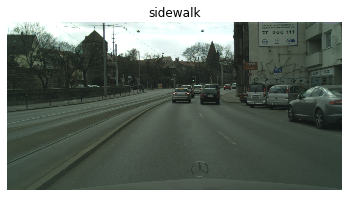

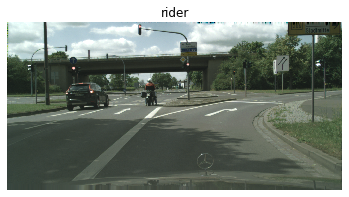

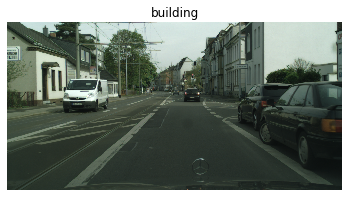

In [15]:
show_random_imgs(3, train_dataset)

In [16]:
def run_epoch(phase):
    for i, (images, targets) in enumerate(dataloaders[phase]):
        print(images.shape)
        print(targets.shape)
        break

In [17]:
run_epoch('train')

torch.Size([16, 3, 1024, 2048])
torch.Size([16, 21])


TypeError: cannot unpack non-iterable NoneType object